In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip
from scipy import optimize
from qutip import *

from functionsSqueeze import wQP, wQQ, wQPdot, wQQdot, H, getParams, plotResults

Units: time in $\mu s$ and circular frequency in MHz<br/>
    $\hbar$ is set to 1 => the hamiltonian has unit MHz

In [84]:
n = 100 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQQ = np.linspace(-0.8, 2.5, 500)
argsQQ = {'n': n,
       'omega': wQQ,
       'omegaDt': wQQdot,
       'omegaArgs': [w0, -0.8*w0, 0.18, -0.8*w0, 0.18, -T + 1.809975],
       'f0': 200/(9*10**-15)}

timesQ = np.linspace(-0.7,0.7, 100)
argsQ = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, -0.8*w0, 0.18, 0, 0, 0],
       'f0': 100/(9*10**-15)}

timesP = np.linspace(-0.1,0.5, 300)
argsP = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, 0, 0.18, 0.5*w0, 4*np.pi/(2*w0), 0.],
       'f0': 0.002/(9*10**-15)}

timesQP = np.linspace(-0.8,1, 900)
argsQP = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, -0.5*w0, 0.18, 0.3*w0, 4*np.pi/(2*w0), 0.3],
       'f0': 0.002/(9*10**-15)}

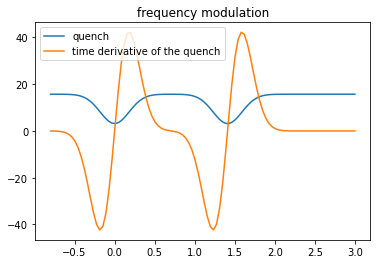

In [85]:
# plot different frequency modulations, to check that they are what I want them to be
tlist = np.linspace(-0.8,3,100)

wDoubleQuench = wQQ(tlist, argsQQ['omegaArgs'])
wDoubleQuenchD = wQQdot(tlist, argsQQ['omegaArgs'])
# wParam = wQP(tlist, argsP['omegaArgs'])
# wBoth = wQP(tlist, argsQP['omegaArgs'])

plt.plot(tlist, wDoubleQuench, label="quench")
plt.plot(tlist, wDoubleQuenchD, label="time derivative of the quench")
# plt.plot(tlist, wParam, label="parametric")
# plt.plot(tlist, wBoth,":", label="first quench, then parametric")
plt.legend()
plt.title("frequency modulation")
plt.show()

In [89]:
resultQQ = mesolve(H, psi0, timesQQ, args=argsQQ)

In [90]:
# resultQ = mesolve(H, psi0, timesQ, args=argsQ)
# resultP = mesolve(H, psi0, timesP, args=argsP)
# resultQP = mesolve(H, psi0, timesQP, args=argsQP)

2.5257912568463308


<function matplotlib.pyplot.show(*args, **kw)>

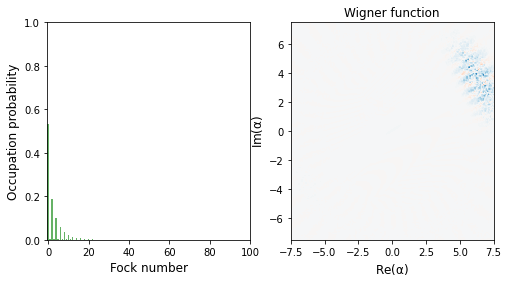

In [91]:
result = resultQQ
print(expect(num(n), result.states[-1]))
psi = result.states[-1]

plot_wigner_fock_distribution(psi)
plt.show

|alpha|= 0.09721524805456902 , xi = (-0.6014436630133859-1.0863154129247752j) , nBar = 2.5257912568463308 , nT = 0.010144385266773262


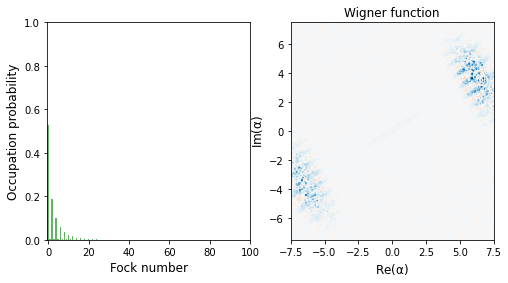

In [92]:
alpha, xi, nBar, nT = getParams(psi)
print('|alpha|=', np.abs(alpha), ', xi =', xi, ', nBar =', nBar, ', nT =', nT)

psi1 = displace(n, alpha)*squeeze(n, xi)*thermal_dm(n, nT)*squeeze(n, xi).dag()*displace(n, alpha).dag()
plot_wigner_fock_distribution(psi1)
plt.show()

 Progress: 100 %

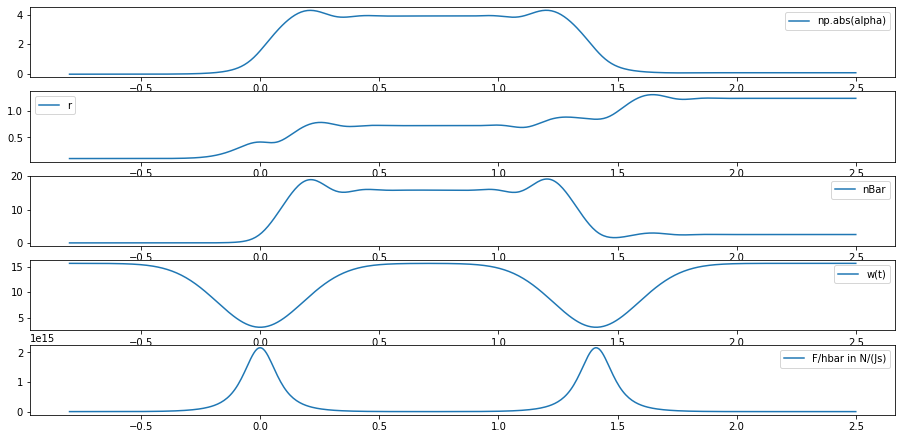

0

In [96]:
plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 1, showProgress = True)

In [71]:
# setup to find the optimal two pulse sequence to minimize coherent displacement
# update argsQQ when a better delay or strength is found

n = 100 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.8*w0, 0.18, -0.8*w0, 0.18, 1.809975],
   'f0': 100/(9*10**-15)}

In [ ]:
# checking how |alpha| behaves when the delay is changed through 1 period T 
delays = np.linspace(4*T, 5*T, 37) # at least 4T, war 37
alphaF = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
for dt in delays:
    times2 = np.linspace(2*T, 3, 200)
    argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution
    
    psi2 = resultQQ.states[-1] # final state
    alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alphaF.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress:", round(100*(dt-delays[0])/(delays[-1]-delays[0])), "%", end = '')

 Progress: 78.0 %

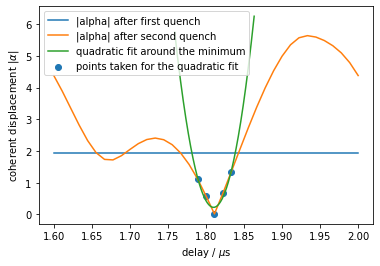

1.8099751290225832


In [78]:
# fit a quadratic polynom on the minimum to get a more exact position
def fitFkt(x, a, b, c):
    return(a*x**2 + b*x + c)

# take two points left and right of the minimum for the quadratic fit
idx = alphaF.index(min(alphaF))
xFit = delays[idx-2:idx+3]
yFit = alphaF[idx-2:idx+3]
params,_ = optimize.curve_fit(fitFkt, xFit, yFit, p0 = [0, 0, 0]) # do the fit

# plot the results from above
plt.plot([delays[0], delays[-1]], [np.abs(alpha1), np.abs(alpha1)], label = "|alpha| after first quench")
plt.plot(delays, alphaF, label = "|alpha| after second quench")

# plot the fit
xlist = np.linspace(xFit[0]-0.03, xFit[-1]+0.03, 1000)
plt.plot(xlist, fitFkt(xlist, params[0], params[1], params[2]), label = "quadratic fit around the minimum")
plt.scatter(xFit, yFit, label = "points taken for the quadratic fit")
plt.legend()
plt.xlabel(r'delay / $\mu$s')
plt.ylabel(r'coherent displacement $|\alpha |$')
plt.show()

delayOpt = -params[1]/(2*params[0])
print(delayOpt)

coherent displacement for different delays between the two pulses <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for delays $\Delta T \in \left[4T, 5T\right]$ (with T = 0.4 $\mu s$ the period of the unpertubed signal) between the two pulses. A minimum is visible in the first half of the peiod.

In [12]:
# check if the number off full periods T between the two quenches plays a role (result: No)
delays = np.linspace(delayOpt, delayOpt + 12*T, 13) # at least 4T
alphaF2 = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha12,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
i = 0
for dt in delays:
    times2 = np.linspace(2*T, dt + 2*T, 200+50*i) # keep spacing the same
    argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution
    
    psi2 = resultQQ.states[-1] # final state
    alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alphaF2.append(np.abs(alpha2)) # save alpha
    i += 1
    print('\r', "Progress: ", round(100*(dt-delays[0])/(delays[-1]-delays[0])), " %", end = '')

 Progress:  100.0  %

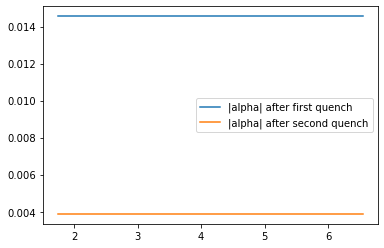

In [13]:
plt.plot([delays[0], delays[-1]], [np.abs(alpha12), np.abs(alpha12)], label = "|alpha| after first quench")
plt.plot(delays, alphaF2, label = "|alpha| after second quench")
plt.legend()
plt.show()

coherent displacement for different delays between the two pulses <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for delays $\Delta T = t_0 + n \cdot T$ (with T = 0.4 $\mu s$ the period of the unpertubed signal, $t_0$ at the minimum from figure above, $n \in \{0, 1, 2, \dots, 12\}$) between the two pulses. No dependance on $n$ is visible.

In [79]:
# check the influence of the second quenches strength (=> should be the same as the first one)
# make sure to use the optimal delay (see above)
dw2s = np.linspace(-0.9, -0.5, 21)
alphaF3 = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha13,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several dw2s and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dw2 in dw2s:
    argsQQ['omegaArgs'][3] = dw2*w0 # only change the secon pule strength in argsQQ    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

    psi2 = resultQQ.states[-1] # final state
    alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alphaF3.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress: ", round(100*(dw2-dw2s[0])/(dw2s[-1]-dw2s[0])), " %", end = '')

 Progress:  100.0  %

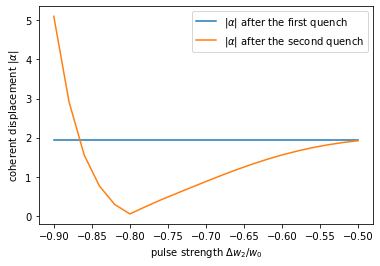

-0.8


In [83]:
plt.plot([dw2s[0], dw2s[-1]], [np.abs(alpha13), np.abs(alpha13)], label = r'$|\alpha|$ after the first quench')
plt.plot(dw2s, alphaF3, label = r'$|\alpha|$ after the second quench')
plt.legend()
plt.xlabel(r'pulse strength $\Delta w_2 / w_0$')
plt.ylabel(r'coherent displacement $|\alpha |$')
plt.show()

dw2Opt = dw2s[alphaF3.index(min(alphaF3))]
print(dw2Opt)

coherent displacement for different strengths of the second pulse <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for different strengths of the second pulse $\Delta w_2 = \gamma \cdot w_0$ (with $w_0 = 2\pi \cdot 2.5$ MHz the unperturbed circular frequency, $\gamma \in \left[-0.8, -0.3\right]$). A minimum is at the position $\Delta w_2 = 0.7 \cdot w_0 = \Delta w_1$ which corresponds to the strength of the first pulse.

In [108]:
# do a grid search around the minimum found
delayOpt = 1.8099751290225832
dw2Opt = -0.8

delaysg = np.linspace(delayOpt - 0.005, delayOpt + 0.01, 4) # Stepsize is 0.005, above it was 0.01
dw2sg = np.linspace(dw2Opt - 0.02, dw2Opt + 0.04, 4) # same stepsize as above
alphaFg = []
paramsListg = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1g,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dt in delaysg:
    for dw2 in dw2sg:
        argsQQ['omegaArgs'][3] = dw2*w0
        argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
        resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

        psi2 = resultQQ.states[-1] # final state
        alpha2g,_,_,_ = getParams(psi2, False) # get alpha
        alphaFg.append(np.abs(alpha2g)) # save alpha
        paramsListg.append([dt, dw2])
        print('\r', "Progress dt:", round(100*(dt-delaysg[0])/(delaysg[-1]-delaysg[0])), "%, Progress dw:", round(100*(dw2-dw2sg[0])/(dw2sg[-1]-dw2sg[0])), " %",end = '')

 Progress dt: 100.0 %, Progress dw: 100.0  %

In [111]:
idxg = alphaFg.index(min(alphaFg))
print(alphaFg[idxg], paramsListg[idxg])

0.09720552515587982 [1.8099751290225832, -0.8]


In [110]:
alphaFg

[0.6952007874140874,
 0.648454931474596,
 0.7973535743695777,
 0.9687033183916214,
 0.5818253219356619,
 0.09720552515587982,
 0.4587931563816423,
 0.8033457649801727,
 0.93161182882958,
 0.4748283327399957,
 0.6114015092336949,
 0.9504960472278922,
 1.4661433970860804,
 1.064338027571201,
 1.084253696236071,
 1.3223082608087409]